# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: {YOUR NAMES}  
Summer Term 2024   

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [ ]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [ ]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Load, clean and split the tabular dataset

**Data description:**  
Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.  

Data is from https://archive.ics.uci.edu/dataset/2/adult

*Disclaimer* numbers below for Neural Networks, etc are outdated, so do not orient on these

**Task:** - download the dataset in python and load it here. Check the dataset size and preliminary artifacts.  

*Hint:*
* How many unique values the target column should have?

In [ ]:
# TODO - download the dataset
!wget https://archive.ics.uci.edu/static/public/2/adult.zip
!unzip adult.zip

--2024-06-09 19:03:23--  https://archive.ics.uci.edu/static/public/2/adult.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.zip.1’

adult.zip.1             [  <=>               ] 605.70K  1.72MB/s    in 0.3s    

2024-06-09 19:03:24 (1.72 MB/s) - ‘adult.zip.1’ saved [620237]

Archive:  adult.zip
  inflating: Index                   
  inflating: adult.data              
  inflating: adult.names             
  inflating: adult.test              
  inflating: old.adult.names         


In [ ]:
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
dataset = pd.read_csv("adult.data" , names=column_names)

In [ ]:
dataset.income.unique()

array([' <=50K', ' >50K'], dtype=object)

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity. Sometimes, even the fact that data is missing could be data itself (think about patients who came or missed doctor appointment). In this case we are going with the most simple way to handle Nans - basically removing such entries.*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 40 items.

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Encode categorical values**   

Use label encodings for categorical variables

*Hint:*
* To make t easier to drop rows with nan values, merge $X$ and $Y$ in the same dataframe

In [ ]:
target_column = 'income'
test_size = 0.2
random_state = 42

In [ ]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans
    '''
    df.dropna(inplace= True)
    return df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical
    if it has <= n unique values
    '''
    for col in df.columns:
      if col not in ignore and pd.api.types.is_numeric_dtype(df[col]):
        if(df[col].nunique()<=n):
          df[col] = df[col].astype('category')
    return df


def remove_columns_by_n(df, condition, n=10, direction='less',
                        ignore=[target_column]):
    '''

    Remove columns with more or less than n unique values.
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    columns_to_drop = []
    for col in df.columns:
      if col not in ignore and pd.api.types.is_numeric_dtype(df[col]):
          unique_values = df[col].nunique()
          if (direction == 'less' and unique_values < n) or (direction == 'more' and unique_values > n):
              columns_to_drop.append(col)
    df = df.drop(columns=columns_to_drop)
    return df

def object_to_categorical(df):
    '''
    Make columns with the 'object' type categorical
    and replace categories with label encodings
    '''
    for col in df.select_dtypes(include=['object']).columns:
      df[col] = df[col].astype('category')
      df[col] = df[col].cat.codes
    return df

In [ ]:
df = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])

df = remove_columns_by_n(df, n=10, direction='less',
                         ignore=[target_column], condition="#TODO")
df = object_to_categorical(df)
df = remove_columns_by_n(df, n=40, direction='more',
                         ignore=[target_column], condition="#TODO")
assert not df.isna().any().any(), 'There are still nans in the dataframe'

In [ ]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(target_column, axis=1)
Y = df[target_column]

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state,stratify=Y)

In [ ]:
Y.value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the target variable?

## Task 1: Create a GradientBoostingClassifier

In [ ]:
## TODO : define the GradientBoostingClassifier,
## train it on the train set and predict on the test set

gb = GradientBoostingClassifier(random_state=random_state)
gb.fit(train_X, train_y)
gb_pred = gb.predict(test_X)

In [ ]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics

print(f"Accuracy: {accuracy_score(test_y, gb_pred)}")
print(f"Precision: {precision_score(test_y, gb_pred)}")
print(f"Recall: {recall_score(test_y, gb_pred)}")

Accuracy: 0.8321817902656226
Precision: 0.696443341604632
Recall: 0.5369897959183674


In [ ]:
## TODO : Write a function which iterates over trees_amount,
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
  for trees in trees_amount:
    gb = GradientBoostingClassifier(n_estimators=trees, random_state=random_state)
    gb.fit(train_X, train_y)

    gb_predictions = gb.predict(test_X)

    print(f"Number of Trees: {trees}")
    print(f"Accuracy: {accuracy_score(test_y, gb_predictions)}")
    print(f"Precision: {precision_score(test_y, gb_predictions)}")
    print(f"Recall: {recall_score(test_y, gb_predictions)}")
    print("\n")


In [ ]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

Number of Trees: 1
Accuracy: 0.7592507293106096
Precision: 0.0
Recall: 0.0




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of Trees: 20
Accuracy: 0.8198986642100414
Precision: 0.7236693091732729
Recall: 0.4075255102040816


Number of Trees: 50
Accuracy: 0.8288039306003377
Precision: 0.7134778510838832
Recall: 0.48278061224489793


Number of Trees: 100
Accuracy: 0.8321817902656226
Precision: 0.696443341604632
Recall: 0.5369897959183674




In [ ]:
## TODO : Write a function which iterates over the learning rate,
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
  for rate in learning_rates:
    gb = GradientBoostingClassifier(learning_rate=rate, n_estimators=trees_amount, random_state=random_state)
    gb.fit(train_X, train_y)

    gb_predictions = gb.predict(test_X)

    print(f"Learning Rate: {rate}")
    print(f"Accuracy: {accuracy_score(test_y, gb_predictions)}")
    print(f"Precision: {precision_score(test_y, gb_predictions)}")
    print(f"Recall: {recall_score(test_y, gb_predictions)}")
    print("\n")



In [ ]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

Learning Rate: 0.1
Accuracy: 0.8321817902656226
Precision: 0.696443341604632
Recall: 0.5369897959183674


Learning Rate: 0.2
Accuracy: 0.8315676339628435
Precision: 0.7011101622544833
Recall: 0.5235969387755102


Learning Rate: 0.3
Accuracy: 0.8321817902656226
Precision: 0.6970954356846473
Recall: 0.5357142857142857


Learning Rate: 0.4
Accuracy: 0.8331030247197911
Precision: 0.7022708158116064
Recall: 0.5325255102040817


Learning Rate: 0.5
Accuracy: 0.8334101028711807
Precision: 0.6955465587044535
Recall: 0.5478316326530612




In [ ]:
## TODO : Write a function which iterates over different depths,
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
  for depth in depths:
    gb = GradientBoostingClassifier(max_depth=depth, n_estimators=50, random_state=random_state)
    gb.fit(train_X, train_y)

    gb_predictions = gb.predict(test_X)

    print(f"Max Depth: {depth}")
    print(f"Accuracy: {accuracy_score(test_y, gb_predictions)}")
    print(f"Precision: {precision_score(test_y, gb_predictions)}")
    print(f"Recall: {recall_score(test_y, gb_predictions)}")
    print("\n")

In [ ]:
max_depth_exploration(train_X, train_y, test_X, test_y)

Max Depth: 1
Accuracy: 0.8198986642100414
Precision: 0.7236693091732729
Recall: 0.4075255102040816


Max Depth: 2
Accuracy: 0.822201750345463
Precision: 0.7242888402625821
Recall: 0.4221938775510204


Max Depth: 3
Accuracy: 0.8288039306003377
Precision: 0.7134778510838832
Recall: 0.48278061224489793


Max Depth: 5
Accuracy: 0.8314140948871488
Precision: 0.6958333333333333
Recall: 0.5325255102040817




**TODO :**   

* How does the max_depth parameter influence the results?
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [ ]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
  feature_importance = clf.feature_importances_
  print(feature_importance)
  sorted_indices = feature_importance.argsort()[::-1]  # Sort indices in descending order
  sorted_importance = feature_importance[sorted_indices]
  print(sorted_indices)
  sorted_columns = X.columns[sorted_indices]

  plt.figure(figsize=(10, 6))
  plt.bar(range(len(sorted_importance)), sorted_importance)
  plt.xticks(range(len(sorted_importance)), sorted_columns, rotation=90)
  plt.xlabel('Feature_Name')
  plt.ylabel('Relative Importance')
  plt.title('Relative Importance of Features')
  plt.tight_layout()
  plt.show()


[0.01819647 0.0020318  0.34079012 0.04976496 0.06697788 0.51206883
 0.00227525 0.00789468]
[5 2 4 3 0 7 6 1]


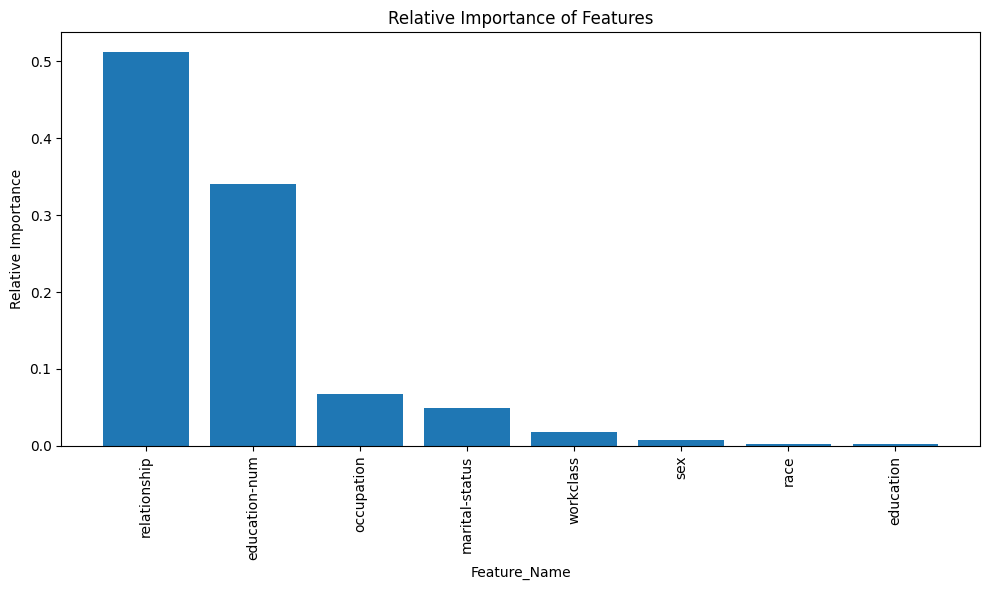

In [ ]:
## TODO : display the plot
plot_explained_variance(gb, train_X)

**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why?

## [OPTIONAL] Implement Tree from scratch


In [ ]:
n_samples = 100000 # our implementation took ~1 min with this amount of samples, you can reduce the number if neccessary
X_train, X_test, y_train, y_test = train_X.to_numpy()[:n_samples], test_X.to_numpy(), train_y.to_numpy()[:n_samples], test_y.to_numpy()


Next, we will implement a simple decision tree classifier ourselves.
We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split in $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Implement a function `gini_impurity(y)` that computes the Gini impurity for an array of labels `y`.
2. Implement a function `weighted_difference(y, split)`, that calculates the removed Gini impurity for a given boolean array `split` and `y`.
3. Implement a function `find_best_split`, that performs an exhaustive search over all possible splits, i.e. for all features in x and all values of these features.

Note: We have converted the training data to numpy above. Please use these arrays for the task. During debugging, it might be a good idea to reduce the number of data points via the n_samples argument above to speed up computations.

In [ ]:
# TODO: Implement the functions gini_impurity and weighted_difference

def gini_impurity(y, labels=(0, 1)):
    pass

def weighted_difference(y, split, labels=(0, 1)):
    pass

In [ ]:
# example application
print(gini_impurity(y_train, labels=(0, 1)))

split = X_train[:,0] < 40
print(weighted_difference(y_train, split))


In [ ]:
# TODO: Implement the function find_best_split
def exhaustive_search(x, y):
    pass

def find_best_split(impurities_array, midpoints_array, features_array, verbose=False):
    pass

In [ ]:
# plotting functionality, works only if you have computed midpoints_array, impurities_array, features_array
fig, ax = plt.subplots(4, 4, figsize=(14, 10), squeeze=False)
ax = ax.flatten()

for i in range(14):
    select_feature = features_array == i
    impurities_feature = impurities_array[select_feature]
    midpoints_feature = midpoints_array[select_feature]

    if i < len(ax):
        ax[i].scatter(midpoints_feature, impurities_feature, s=4)
        ax[i].set_title(f'Feature {i}')
    ax[i].set_xlabel('Split Value')
    ax[i].set_ylabel('Impurity Reduction')

# Hide unused axes if any
for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.


In [ ]:
class Node:
    def __init__(self, left, right, n_feat, threshold):
        self.left = left
        self.right = right
        self.n_feat = n_feat
        self.threshold = threshold


class Leaf:
    def __init__(self, label):
        self.label = label

In [ ]:
# TODO: implement the function build_tree and predict_tree

# Implement recursive tree function
def build_tree(x, y, current_depth, max_depth=3, n_labels=2):
    pass


def predict_tree(node, x):
    pass

In [ ]:
# Build tree
tree = build_tree(X_train, y_train, current_depth=0, max_depth=3, n_labels=2)
predictions = predict_tree(tree, X_test)
predictions

In [ ]:
# Calculate training and test scores
print('Accuracy Training: ', accuracy_score(y_train, predict_tree(tree, X_train)))
print('Accuracy: ', accuracy_score(test_y, predictions))
print('Precision: ', precision_score(test_y, predictions, average='macro'))
print('Recall: ', recall_score(test_y, predictions, average='macro'))

## Prepare for deep learning
### Add all the necessary training functions
*You can reuse them from previous practical exercises*

In [ ]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3

def accuracy(correct, total):
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    if total == 0:
        return 0
    else:
        return correct / total

In [ ]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    model.train()
    t_loss = 0
    correct = 0
    total = 0
    for data, labels in dataloader:
      data, labels = data.to(device), labels.to(device)
      outputs = model(data)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      t_loss += loss.item()

      # Compute accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    return t_loss / len(dataloader) , accuracy(correct, total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    model.eval()
    t_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            t_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return t_loss / len(dataloader) , accuracy(correct, total)

In [ ]:
#TODO write a run_training function that
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    master_bar = trange(num_epochs, desc='Epochs')
    for epoch in master_bar:
        # Train the model

        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device,master_bar)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate the model
        val_loss, val_acc = validate(val_dataloader, model, loss_function, device,master_bar)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # master_bar.set_postfix(train_loss=train_loss, val_loss=val_loss, train_acc=train_acc, val_acc=val_acc)
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


    return train_losses, val_losses, train_accs, val_accs

In [ ]:
# TODO write a plot_model_progress function
## It should plot epochs vs metric progress
## Hint - you can use yours from practical 2 or 3

def plot_model_progress(all_models, metric_progress):
  if(metric_progress == "acc"):
    print("Here")
    i,j = 2,3
    ls = "--"
  else:
    i,j = 0,1
    ls = None
  for model,values in all_models.items():
    # print(values[0])
    sns.lineplot(x=range(1, len(values[0])+1), y=values[i], label=f'{str(metric_progress)} (LR={str(model)})', linestyle=ls, marker='o',legend = False)
    sns.lineplot(x=range(1, len(values[0])+1), y=values[j], label=f'{str(metric_progress)} (LR={str(model)})', linestyle=ls, marker='o',legend = False)

  plt.legend(loc='upper right', prop={'size': 4})
  # plt.ylim(0, 2500)
  # plt.yscale("log")
  plt.xlabel("Epoch")
  plt.ylabel(str(metric_progress))
  plt.title(f'Epoch vs. {str(metric_progress)}')
  plt.show()

all_models = {}

### Convert a pandas dataframe to a PyTorch dataset

In [ ]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes,
        x is data without target column
        y is target column
        transform df to_numpy
        '''
        self.x = df_x.to_numpy()
        self.y = df_y.to_numpy().astype(int)
        self.mean = mean
        self.std = std
        self.normalise = normalise

        if self.normalise:
            if self.mean is None or self.std is None:
                self.mean = self.x.mean(axis=0)
                self.std = self.x.std(axis=0)

    def __len__(self):
        # TODO: return the length of the whole dataset
        return len(self.x)

    def __getitem__(self, index):
        ## TODO: return X, y by index, normalized if needed
        sample = self.x[index]
        label = self.y[index] - self.y.min()

        if self.normalise:
            sample = (sample - self.mean) / self.std

        return sample, label

In [ ]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical
## Hint : the response variable should be of datatype integer

tmp_dataset = TabularDataset(train_X, train_y, normalise=False)

data = tmp_dataset.x
x_mean = np.mean(data, axis=0)
x_std = np.std(data, axis=0)

print("Mean:")
print(x_mean)
print("\nStandard Deviation:")
print(x_std)


Mean:
[ 3.86893428 10.29587684 10.07966063  2.61117936  6.58564957  1.4379223
  3.66911087  0.66934122]

Standard Deviation:
[1.46061287 3.86505857 2.58313628 1.50854986 4.2234179  1.60192725
 0.84459427 0.47045037]


In [ ]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!
conductor_train = TabularDataset(train_X, train_y, mean=x_mean, std=x_std, normalise=True)
conductor_test = TabularDataset(test_X, test_y, mean=x_mean, std=x_std, normalise=True)


## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256
train_loader = DataLoader(conductor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(conductor_test, batch_size=batch_size, shuffle=False)

## Logistic regression

In [ ]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO define linear layer for the model
        self.flatten = nn.Flatten(1)
        self.linear =  nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        # TODO run the data through the layer
        x = self.flatten(x)
        outputs = self.linear(x)
        return outputs

In [ ]:

train_dataloader_iter = iter(train_loader)

data, labels = next(train_dataloader_iter)
# TODO print the dimensions of for elements from the previous step
print(data.shape)
print(labels.shape)

torch.Size([256, 8])
torch.Size([256])


In [ ]:
## TODO define model, loss and optimizers
## don't forget to move everything for the correct devices
##
lr=0.001
n_inputs = 8
n_outputs = 2 # number of classes
lr_model = LR(n_inputs, n_outputs)
optimizer = torch.optim.Adam(lr_model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
lr_model.to(device)





LR(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=8, out_features=2, bias=True)
)

In [ ]:
## TODO train the network
num_epochs = 30

train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr = run_training(lr_model, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

Epochs:   3%|▎         | 1/30 [00:01<00:33,  1.17s/it]

 Train Loss: 0.7590, Train Acc: 0.5083, Val Loss: 0.6965, Val Acc: 0.5752


Epochs:   7%|▋         | 2/30 [00:02<00:32,  1.18s/it]

 Train Loss: 0.6585, Train Acc: 0.6189, Val Loss: 0.6187, Val Acc: 0.6742


Epochs:  10%|█         | 3/30 [00:03<00:28,  1.07s/it]

 Train Loss: 0.5944, Train Acc: 0.6979, Val Loss: 0.5669, Val Acc: 0.7275


Epochs:  13%|█▎        | 4/30 [00:04<00:24,  1.06it/s]

 Train Loss: 0.5506, Train Acc: 0.7412, Val Loss: 0.5306, Val Acc: 0.7645


Epochs:  17%|█▋        | 5/30 [00:04<00:21,  1.16it/s]

 Train Loss: 0.5197, Train Acc: 0.7808, Val Loss: 0.5050, Val Acc: 0.7872


Epochs:  20%|██        | 6/30 [00:05<00:19,  1.22it/s]

 Train Loss: 0.4976, Train Acc: 0.7959, Val Loss: 0.4866, Val Acc: 0.7993


Epochs:  23%|██▎       | 7/30 [00:06<00:18,  1.28it/s]

 Train Loss: 0.4818, Train Acc: 0.8021, Val Loss: 0.4733, Val Acc: 0.8039


Epochs:  27%|██▋       | 8/30 [00:06<00:16,  1.31it/s]

 Train Loss: 0.4705, Train Acc: 0.8052, Val Loss: 0.4638, Val Acc: 0.8065


Epochs:  30%|███       | 9/30 [00:07<00:15,  1.33it/s]

 Train Loss: 0.4622, Train Acc: 0.8061, Val Loss: 0.4569, Val Acc: 0.8065


Epochs:  33%|███▎      | 10/30 [00:08<00:15,  1.33it/s]

 Train Loss: 0.4564, Train Acc: 0.8071, Val Loss: 0.4519, Val Acc: 0.8065


Epochs:  37%|███▋      | 11/30 [00:09<00:14,  1.34it/s]

 Train Loss: 0.4521, Train Acc: 0.8072, Val Loss: 0.4482, Val Acc: 0.8070


Epochs:  40%|████      | 12/30 [00:09<00:13,  1.35it/s]

 Train Loss: 0.4490, Train Acc: 0.8074, Val Loss: 0.4456, Val Acc: 0.8079


Epochs:  43%|████▎     | 13/30 [00:10<00:12,  1.35it/s]

 Train Loss: 0.4465, Train Acc: 0.8076, Val Loss: 0.4437, Val Acc: 0.8084


Epochs:  47%|████▋     | 14/30 [00:11<00:11,  1.36it/s]

 Train Loss: 0.4451, Train Acc: 0.8073, Val Loss: 0.4424, Val Acc: 0.8079


Epochs:  50%|█████     | 15/30 [00:12<00:10,  1.37it/s]

 Train Loss: 0.4438, Train Acc: 0.8077, Val Loss: 0.4415, Val Acc: 0.8088


Epochs:  53%|█████▎    | 16/30 [00:12<00:10,  1.39it/s]

 Train Loss: 0.4433, Train Acc: 0.8074, Val Loss: 0.4407, Val Acc: 0.8084


Epochs:  57%|█████▋    | 17/30 [00:13<00:10,  1.21it/s]

 Train Loss: 0.4426, Train Acc: 0.8076, Val Loss: 0.4401, Val Acc: 0.8079


Epochs:  60%|██████    | 18/30 [00:14<00:11,  1.09it/s]

 Train Loss: 0.4422, Train Acc: 0.8077, Val Loss: 0.4399, Val Acc: 0.8079


Epochs:  63%|██████▎   | 19/30 [00:16<00:10,  1.01it/s]

 Train Loss: 0.4418, Train Acc: 0.8075, Val Loss: 0.4396, Val Acc: 0.8087


Epochs:  67%|██████▋   | 20/30 [00:17<00:09,  1.03it/s]

 Train Loss: 0.4417, Train Acc: 0.8077, Val Loss: 0.4395, Val Acc: 0.8082


Epochs:  70%|███████   | 21/30 [00:17<00:08,  1.11it/s]

 Train Loss: 0.4415, Train Acc: 0.8081, Val Loss: 0.4393, Val Acc: 0.8076


Epochs:  73%|███████▎  | 22/30 [00:18<00:06,  1.18it/s]

 Train Loss: 0.4414, Train Acc: 0.8075, Val Loss: 0.4392, Val Acc: 0.8076


Epochs:  77%|███████▋  | 23/30 [00:19<00:05,  1.23it/s]

 Train Loss: 0.4415, Train Acc: 0.8075, Val Loss: 0.4393, Val Acc: 0.8073


Epochs:  80%|████████  | 24/30 [00:19<00:04,  1.27it/s]

 Train Loss: 0.4411, Train Acc: 0.8078, Val Loss: 0.4392, Val Acc: 0.8075


Epochs:  83%|████████▎ | 25/30 [00:20<00:03,  1.27it/s]

 Train Loss: 0.4413, Train Acc: 0.8076, Val Loss: 0.4392, Val Acc: 0.8078


Epochs:  87%|████████▋ | 26/30 [00:22<00:04,  1.07s/it]

 Train Loss: 0.4412, Train Acc: 0.8075, Val Loss: 0.4392, Val Acc: 0.8081


Epochs:  90%|█████████ | 27/30 [00:25<00:04,  1.56s/it]

 Train Loss: 0.4413, Train Acc: 0.8075, Val Loss: 0.4392, Val Acc: 0.8078


Epochs:  93%|█████████▎| 28/30 [00:28<00:04,  2.16s/it]

 Train Loss: 0.4415, Train Acc: 0.8074, Val Loss: 0.4391, Val Acc: 0.8078


Epochs:  97%|█████████▋| 29/30 [00:32<00:02,  2.68s/it]

 Train Loss: 0.4413, Train Acc: 0.8075, Val Loss: 0.4393, Val Acc: 0.8082


Epochs: 100%|██████████| 30/30 [00:35<00:00,  1.19s/it]

 Train Loss: 0.4415, Train Acc: 0.8074, Val Loss: 0.4393, Val Acc: 0.8081


In [ ]:
all_models["LR"] = train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr

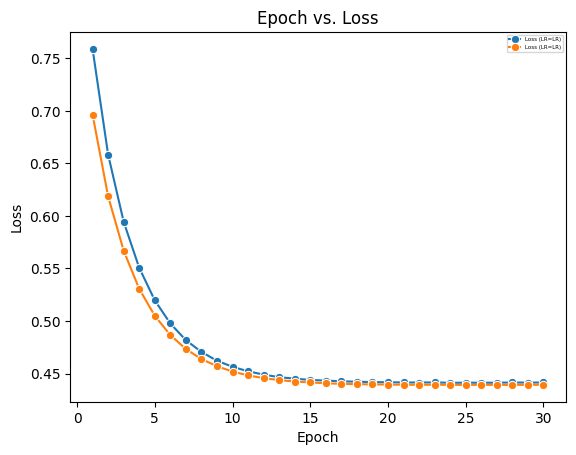

In [ ]:
## todo - plot epochs vs loss with plot_model_progress

plot_model_progress(all_models,"Loss")

Here


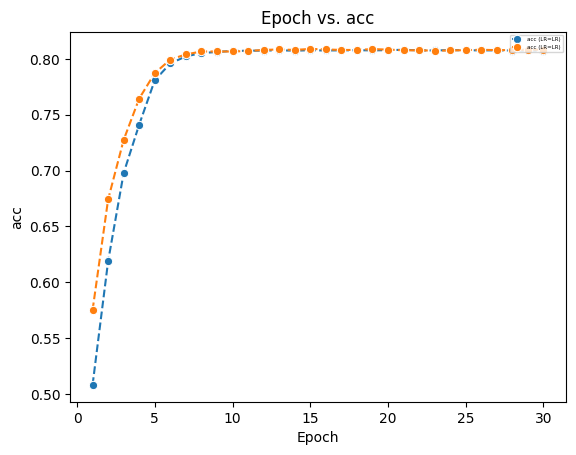

In [ ]:
## todo - plot epochs and accuracy with plot_model_progress
plot_model_progress(all_models,"acc")



## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

In [ ]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, output_dim)
        )


    def forward(self, x):
        """ Defines the computation performed at every call. """
        # TODO
        if x.dtype != torch.float32:
            x = x.float()
        return self.network(x)

In [ ]:
## TODO : define model, optimizer, cross entropy loss,
## put model to the device, and train mode
## you can optionally try to add regularization

lr=0.001
input_dim = 8
output_dim = 2 # number of classes
reg_mlp_model = TabularNetwork(input_dim, output_dim)
reg_mlp_model.to(device)
reg_mlp_model.train()
optimizer = torch.optim.Adam(reg_mlp_model.parameters(), lr=lr, weight_decay=0.00005)
loss_function = nn.CrossEntropyLoss()

In [ ]:
## TODO : Train model
num_epochs = 30
train_losses_mlp_reg, val_losses_mlp_reg, train_accs_mlp_reg, val_accs_mlp_reg  = run_training(reg_mlp_model, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

Epochs:   3%|▎         | 1/30 [00:00<00:22,  1.29it/s]

 Train Loss: 0.6156, Train Acc: 0.7512, Val Loss: 0.5756, Val Acc: 0.7593


Epochs:   7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

 Train Loss: 0.5463, Train Acc: 0.7592, Val Loss: 0.5178, Val Acc: 0.7593


Epochs:  10%|█         | 3/30 [00:02<00:20,  1.29it/s]

 Train Loss: 0.4989, Train Acc: 0.7592, Val Loss: 0.4778, Val Acc: 0.7594


Epochs:  13%|█▎        | 4/30 [00:03<00:20,  1.27it/s]

 Train Loss: 0.4645, Train Acc: 0.7823, Val Loss: 0.4489, Val Acc: 0.8024


Epochs:  17%|█▋        | 5/30 [00:04<00:25,  1.01s/it]

 Train Loss: 0.4438, Train Acc: 0.8084, Val Loss: 0.4329, Val Acc: 0.8090


Epochs:  20%|██        | 6/30 [00:05<00:26,  1.11s/it]

 Train Loss: 0.4327, Train Acc: 0.8090, Val Loss: 0.4239, Val Acc: 0.8085


Epochs:  23%|██▎       | 7/30 [00:06<00:24,  1.07s/it]

 Train Loss: 0.4262, Train Acc: 0.8088, Val Loss: 0.4180, Val Acc: 0.8093


Epochs:  27%|██▋       | 8/30 [00:08<00:28,  1.31s/it]

 Train Loss: 0.4216, Train Acc: 0.8104, Val Loss: 0.4134, Val Acc: 0.8111


Epochs:  30%|███       | 9/30 [00:10<00:31,  1.52s/it]

 Train Loss: 0.4177, Train Acc: 0.8107, Val Loss: 0.4097, Val Acc: 0.8122


Epochs:  33%|███▎      | 10/30 [00:12<00:30,  1.52s/it]

 Train Loss: 0.4142, Train Acc: 0.8114, Val Loss: 0.4061, Val Acc: 0.8131


Epochs:  37%|███▋      | 11/30 [00:13<00:25,  1.35s/it]

 Train Loss: 0.4106, Train Acc: 0.8122, Val Loss: 0.4026, Val Acc: 0.8144


Epochs:  40%|████      | 12/30 [00:13<00:21,  1.19s/it]

 Train Loss: 0.4071, Train Acc: 0.8122, Val Loss: 0.3994, Val Acc: 0.8151


Epochs:  43%|████▎     | 13/30 [00:15<00:20,  1.23s/it]

 Train Loss: 0.4038, Train Acc: 0.8135, Val Loss: 0.3966, Val Acc: 0.8154


Epochs:  47%|████▋     | 14/30 [00:16<00:20,  1.26s/it]

 Train Loss: 0.4007, Train Acc: 0.8146, Val Loss: 0.3938, Val Acc: 0.8176


Epochs:  50%|█████     | 15/30 [00:17<00:19,  1.29s/it]

 Train Loss: 0.3979, Train Acc: 0.8175, Val Loss: 0.3916, Val Acc: 0.8211


Epochs:  53%|█████▎    | 16/30 [00:18<00:16,  1.20s/it]

 Train Loss: 0.3958, Train Acc: 0.8183, Val Loss: 0.3898, Val Acc: 0.8207


Epochs:  57%|█████▋    | 17/30 [00:19<00:13,  1.08s/it]

 Train Loss: 0.3940, Train Acc: 0.8191, Val Loss: 0.3887, Val Acc: 0.8214


Epochs:  60%|██████    | 18/30 [00:20<00:11,  1.01it/s]

 Train Loss: 0.3923, Train Acc: 0.8193, Val Loss: 0.3877, Val Acc: 0.8220


Epochs:  63%|██████▎   | 19/30 [00:21<00:10,  1.00it/s]

 Train Loss: 0.3908, Train Acc: 0.8196, Val Loss: 0.3868, Val Acc: 0.8225


Epochs:  67%|██████▋   | 20/30 [00:22<00:10,  1.07s/it]

 Train Loss: 0.3897, Train Acc: 0.8199, Val Loss: 0.3862, Val Acc: 0.8225


Epochs:  70%|███████   | 21/30 [00:24<00:10,  1.12s/it]

 Train Loss: 0.3888, Train Acc: 0.8205, Val Loss: 0.3859, Val Acc: 0.8224


Epochs:  73%|███████▎  | 22/30 [00:25<00:09,  1.18s/it]

 Train Loss: 0.3883, Train Acc: 0.8194, Val Loss: 0.3857, Val Acc: 0.8222


Epochs:  77%|███████▋  | 23/30 [00:26<00:09,  1.29s/it]

 Train Loss: 0.3878, Train Acc: 0.8198, Val Loss: 0.3856, Val Acc: 0.8220


Epochs:  80%|████████  | 24/30 [00:28<00:08,  1.36s/it]

 Train Loss: 0.3876, Train Acc: 0.8201, Val Loss: 0.3855, Val Acc: 0.8225


Epochs:  83%|████████▎ | 25/30 [00:29<00:06,  1.35s/it]

 Train Loss: 0.3867, Train Acc: 0.8204, Val Loss: 0.3855, Val Acc: 0.8214


Epochs:  87%|████████▋ | 26/30 [00:31<00:06,  1.58s/it]

 Train Loss: 0.3867, Train Acc: 0.8198, Val Loss: 0.3853, Val Acc: 0.8219


Epochs:  90%|█████████ | 27/30 [00:32<00:04,  1.34s/it]

 Train Loss: 0.3862, Train Acc: 0.8201, Val Loss: 0.3852, Val Acc: 0.8217


Epochs:  93%|█████████▎| 28/30 [00:33<00:02,  1.16s/it]

 Train Loss: 0.3860, Train Acc: 0.8200, Val Loss: 0.3850, Val Acc: 0.8220


Epochs:  97%|█████████▋| 29/30 [00:34<00:01,  1.06s/it]

 Train Loss: 0.3858, Train Acc: 0.8204, Val Loss: 0.3847, Val Acc: 0.8216


Epochs: 100%|██████████| 30/30 [00:35<00:00,  1.17s/it]

 Train Loss: 0.3855, Train Acc: 0.8210, Val Loss: 0.3845, Val Acc: 0.8225


In [ ]:
all_models["mlp+reg"] = train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr

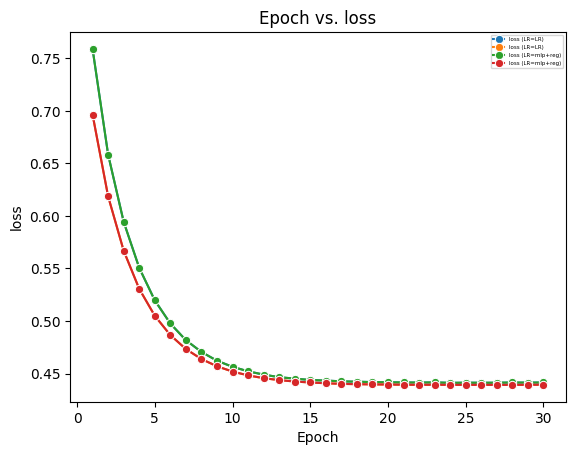

In [ ]:
## todo - plot epochs vs loss with plot_model_progress
plot_model_progress(all_models,"loss")

Here


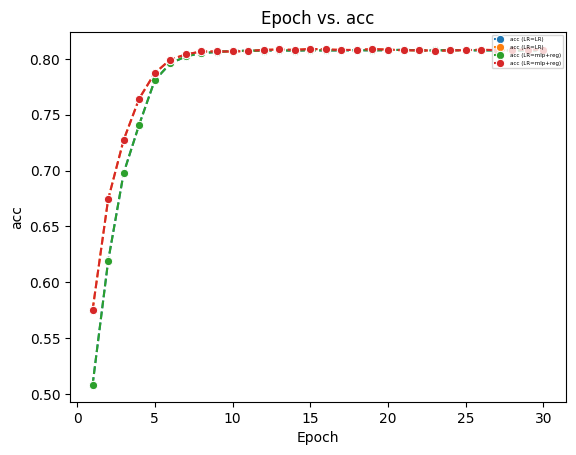

In [ ]:
## todo - plot epochs and accuracy with plot_model_progress
plot_model_progress(all_models,"acc")

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why?


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimizer. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/